# <span style="color:blue">EVAC Workshop 2: GAs for classification</span>

**Module leader**

Simon O'Keefe: simon.okeefe@york.ac.uk

**Graduate Teaching Assistants**

Danny Roberts: danny.roberts@york.ac.uk

Tianda Sun: tianda.sun@york.ac.uk

## <span style="color:#0073e6">Prerequisites</span>

Before participating in this practical make sure that you have watched the the pre-workshop materials:
- Code walkthrough 3
- Code walkthrough 4

## <span style="color:#0073e6">Topics</span>

- Exploring data
- Cleaning data
- Balancing data
- Evolving a solution to classify on data

## <span style="color:#0073e6">Learning Objectives</span>

- To understand the basics of how to explore, clean, and balance data  
- To understand the challenges of training on data and making predictions  
- To understand the need to define your own representation for the problem with a GA  

# <span style="color:blue">Your Task</span>

Implement a genetic algorithm to classify different types of iris flowers. The classic dataset contains measurements of iris flowers, along with what type of flower they are. The idea is to classify whether the flower is a Versicolor (0), Setosa (1), or Virginica (2). Classify the flowers from the features in the data.

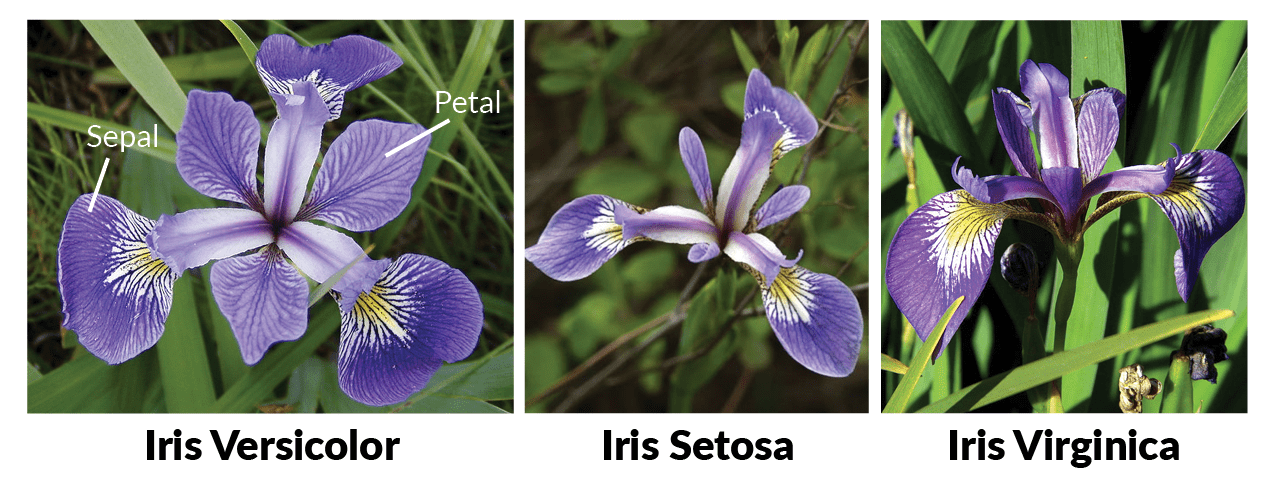

The approach is similar to that in walkthrough 3, but you should try to do this yourself, giving thought to what decisions are being made as you go through. You can reach to the notebook for walkthrough 3 when you need it.

**To keep things simple, you can remove one of the flowers and use a binary regression.**

However, if you would like to attempt a Softmax regression, after doing this, here is a good link to find out more:

http://rasbt.github.io/mlxtend/user_guide/classifier/SoftmaxRegression/

Tips:
- Examine the data properly before implementing your algorithm.
- Use summary statistics and plots.
- Check for missing data and class imbalance.
- Explore different operators etc
- If you finish, you can find a dataset on Kaggle and have a go at a time-series regression problem (e.g. https://www.kaggle.com/bulentsiyah/for-simple-exercises-time-series-forecasting).

## <span style="color:#0073e6">Reading the dataset</span>

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

iris = load_iris()

# Convert it into a Pandas dataframe
iris_data = pd.DataFrame(
    data=np.c_[iris["data"], iris["target"]], columns=iris["feature_names"] + ["target"]
)

## <span style="color:#0073e6">Exploring the dataset</span>

In [6]:
iris_data.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [7]:
iris_data["target"].value_counts()

target
0.0    50
1.0    50
2.0    50
Name: count, dtype: int64

In [8]:
iris_data.isnull().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
dtype: int64

## Remove one of the classes for a binary classifier

In [9]:
iris_data = iris_data[iris_data["target"] != 2]

In [10]:
iris_data["target"].value_counts()

target
0.0    50
1.0    50
Name: count, dtype: int64

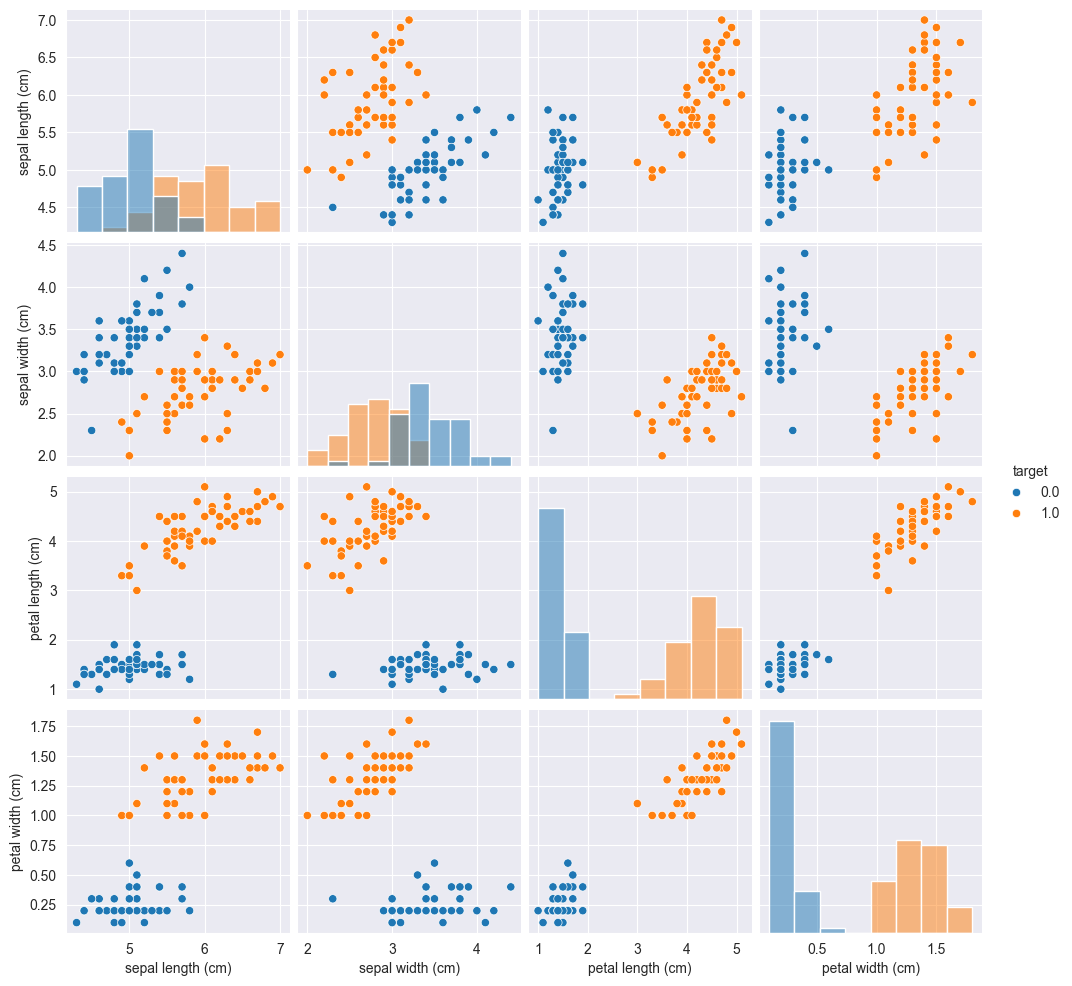

In [11]:
import seaborn as sns

sns.pairplot(iris_data, hue="target", diag_kind="hist")

# <span style="color:blue">Add your GA code below</span>

### Divide up data

In [12]:
X = iris_data.drop("target", axis=1)
y = iris_data["target"]

### From examining the data, the ratio between classes is already even. Therefore, we do not need a stratified split here

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [14]:
N_WEIGHTS_PLUS_INTERCEPT = len(X_train.columns) + 1

In [15]:
from deap import base
from deap import creator
from deap import tools
import random

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register(
    "individual",
    tools.initRepeat,
    creator.Individual,
    toolbox.attr_float,
    N_WEIGHTS_PLUS_INTERCEPT,
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [16]:
import math


def sigmoid(x):
    return 1 / (1 + math.exp(-x))


def prediction(individual, row):
    regr = individual[0] + sum(i * r for i, r in zip(individual[1:4], row))
    return float(sigmoid(regr))


def evalAccuracyTrain(individual, X_train, y_train):
    y_pred = [None] * X_train.shape[0]

    index = 0
    for i, row in X_train.iterrows():
        y_pred[index] = prediction(individual, row)
        index += 1

    # calculate mean squared difference (using the training set)
    diff = (np.array(y_pred) - np.array(y_train)) ** 2
    return (sum(diff),)


toolbox.register("evaluate", evalAccuracyTrain)

In [17]:
toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.4, indpb=0.2)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("select", tools.selTournament, tournsize=3)

In [18]:
NGEN, CXPB = 30, 0.2
pop = toolbox.population(n=200)

fitnesses = [toolbox.evaluate(ind, X_train, y_train) for ind in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit
for g in range(NGEN):
    print("-- Generation %i --" % g)
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values

    invalid_inds = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(ind, X_train, y_train) for ind in invalid_inds]
    for ind, fit in zip(invalid_inds, fitnesses):
        ind.fitness.values = fit

    best_ind = tools.selBest(pop, 1)[0]
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    pop[:] = offspring

-- Generation 0 --
Best individual is [-0.7946625213998917, -0.4238292608562968, 0.17636616694063045, 0.9686142713253598, 0.43273900053084224], (5.54452519638708,)
-- Generation 1 --
Best individual is [-0.0731366201095025, -0.8417281497900637, 0.12088657756293686, 1.4887527849186997, 0.7207848736819735], (2.501023459138216,)
-- Generation 2 --
Best individual is [-0.6826563361934507, -0.06111273709674725, -1.068238488722636, 1.2652337339776334, 0.45862513507276703], (2.0697285109272165,)
-- Generation 3 --
Best individual is [0.4883896854959251, -0.05574452657835027, -1.1525136683692492, 1.2183480838312648, -0.2313322745116334], (1.4470738615165197,)
-- Generation 4 --
Best individual is [0.4883896854959251, -0.05574452657835027, -1.1525136683692492, 1.2183480838312648, -0.2313322745116334], (1.4470738615165197,)
-- Generation 5 --
Best individual is [-0.8992674210370594, 0.07099032923619247, -1.1328407839175194, 1.3604119645479464, 0.1393881826202802], (0.9832023698086236,)
-- Genera

In [19]:
from sklearn.metrics import accuracy_score

y_pred = [None] * X_test.shape[0]
index = 0
for i, row in X_test.iterrows():
    y_pred[index] = prediction(best_ind, row)
    index += 1

y_bin_pred = np.array(y_pred) > 0.5
accuracy = accuracy_score(y_test, y_bin_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%


# Softmax classifier

In [20]:
iris = load_iris()

# Convert it into a Pandas dataframe
iris_data = pd.DataFrame(
    data=np.c_[iris["data"], iris["target"]], columns=iris["feature_names"] + ["target"]
)
X = iris_data.drop("target", axis=1)
X["bias"] = 1
y = iris_data["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [21]:
def softmax_regression(X, theta):
    scores = X.dot(theta)
    probs = (np.exp(scores.T) / np.sum(np.exp(scores), axis=1)).T
    return probs


def to_classlabel(probs):
    return probs.to_numpy().argmax(axis=1)


def cross_entropy(output, y_target):
    return -np.sum(np.log(output) * y_target, axis=1)


def one_hot_enc(labels):
    enc = np.zeros((len(labels), int(max(labels) + 1)))
    for i in range(len(labels)):
        enc[i][int(np.array(labels)[i])] = 1
    return enc


def eval_softmax(ind, X, y):
    return (np.mean(cross_entropy(softmax_regression(X, ind), one_hot_enc(y))),)


indv1 = np.random.rand(5, 3)
eval_softmax(indv1, X_train, y_train)

(3.1615222784782158,)

In [22]:
toolbox.register("evaluate_softmax", eval_softmax)


toolbox.register("attr_float_matrix", np.random.rand, 3)
toolbox.register(
    "individual", tools.initRepeat, creator.Individual, toolbox.attr_float_matrix, n=5
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)

In [23]:
NGEN, CXPB = 100, 0.2
pop = toolbox.population(n=200)
fitnesses = [toolbox.evaluate_softmax(ind, X_train, y_train) for ind in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit
for g in range(NGEN):
    print("-- Generation %i --" % g)
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values

    invalid_inds = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [
        toolbox.evaluate_softmax(ind, X_train, y_train) for ind in invalid_inds
    ]
    for ind, fit in zip(invalid_inds, fitnesses):
        ind.fitness.values = fit

    best_ind = tools.selBest(pop, 1)[0]

    softmax_pred = to_classlabel(softmax_regression(X_test, best_ind))
    accuracy = accuracy_score(y_test, np.array(softmax_pred))
    print(f"Best individual: {best_ind}")
    print(f"Best fitness: {best_ind.fitness.values}, accuracy: {accuracy * 100.0}%")
    pop[:] = offspring

-- Generation 0 --
Best individual: [array([0.42414509, 0.70198232, 0.32439686]), array([0.97580873, 0.25086694, 0.19116178]), array([0.52363065, 0.27804497, 0.95487176]), array([0.05500765, 0.63987288, 0.35550998]), array([0.03063587, 0.67824646, 0.36748829])]
Best fitness: (0.8175387231032402,), accuracy: 63.33333333333333%
-- Generation 1 --
Best individual: [array([0.42414509, 0.70198232, 0.32439686]), array([0.97580873, 0.25086694, 0.19116178]), array([0.52363065, 0.27804497, 0.95487176]), array([0.05500765, 0.63987288, 0.35550998]), array([-0.96609728, -0.31848668, -0.62924485])]
Best fitness: (0.81753872310324,), accuracy: 63.33333333333333%
-- Generation 2 --
Best individual: [array([1.04332633, 1.3186775 , 1.22792338]), array([0.94408782, 0.38480965, 0.32271847]), array([0.25554728, 0.57916387, 0.69161547]), array([0.14607016, 0.39016636, 0.56391854]), array([0.92484458, 0.08381347, 0.19777199])]
Best fitness: (0.7001045097449555,), accuracy: 56.666666666666664%
-- Generation 

## Try running the algorighm multiple times

In [24]:
NGEN, CXPB = 50, 0.2
accuracy_hist = []
for run in range(20):
    print("-- Run %i --" % run)
    pop = toolbox.population(n=100)
    fitnesses = [toolbox.evaluate_softmax(ind, X_train, y_train) for ind in pop]
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    for g in range(NGEN):
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            toolbox.mutate(mutant)
            del mutant.fitness.values

        invalid_inds = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = [
            toolbox.evaluate_softmax(ind, X_train, y_train) for ind in invalid_inds
        ]
        for ind, fit in zip(invalid_inds, fitnesses):
            ind.fitness.values = fit

    best_ind = tools.selBest(pop, 1)[0]

    softmax_pred = to_classlabel(softmax_regression(X_test, best_ind))
    accuracy = accuracy_score(y_test, np.array(softmax_pred))
    print(f"Best fitness: {best_ind.fitness.values}, accuracy: {accuracy * 100.0}%")
    pop[:] = offspring
    accuracy_hist.append(accuracy * 100.0)

-- Run 0 --
Best fitness: (0.7576779253494474,), accuracy: 66.66666666666666%
-- Run 1 --
Best fitness: (0.7790719034640752,), accuracy: 56.666666666666664%
-- Run 2 --
Best fitness: (0.91521135444406,), accuracy: 36.666666666666664%
-- Run 3 --
Best fitness: (0.8459615010568647,), accuracy: 56.666666666666664%
-- Run 4 --


KeyboardInterrupt: 

In [ ]:
plt.hist(accuracy_hist)

In [76]:
import numpy as np
STRING_TO_GUESS = 'sixteenletterstr'

def loss_test_string(ind: str) -> tuple:
    return (sum([(ord(guess_char) - ord(actual_char)) ** 2 for (guess_char, actual_char) in zip(STRING_TO_GUESS, ind)]), )

def loss_test_string_strict(ind: str) -> tuple:
    return (sum([0 if guess_char == actual_char else 1 for (guess_char, actual_char) in zip(STRING_TO_GUESS, ind)]), )

In [77]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox.register("attr_string", random.choice, 'abcdefghijklmnopqrstuvwxyz')
toolbox.register(
    "individual",
    tools.initRepeat,
    creator.Individual,
    toolbox.attr_string,
    16,
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate_string", loss_test_string_strict)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.1)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("select", tools.selTournament, tournsize=3)

/Users/ivanbar/Library/Python/3.9/lib/python/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/ivanbar/Library/Python/3.9/lib/python/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [78]:
NGEN, CXPB = 300, 0.5
pop = toolbox.population(n=200)
print(pop[0])
fitnesses = [toolbox.evaluate_string(ind) for ind in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit
for g in range(NGEN):
    print("-- Generation %i --" % g)
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values

    invalid_inds = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [
        toolbox.evaluate_string(ind) for ind in invalid_inds
    ]
    for ind, fit in zip(invalid_inds, fitnesses):
        ind.fitness.values = fit

    best_ind = tools.selBest(pop, 1)[0]
    pop[:] = offspring
    print(f"Best individual: {''.join(best_ind)}, best fitness: {best_ind.fitness.values}")

['h', 'a', 'g', 'u', 'k', 'h', 'b', 'h', 't', 'o', 'c', 'w', 'j', 'z', 'e', 't']
-- Generation 0 --
Best individual: csxzqjivrktbzsly, best fitness: (13.0,)
-- Generation 1 --
Best individual: gyxwcozueqxhdcqr, best fitness: (13.0,)
-- Generation 2 --
Best individual: uiduqvljzztbrsyi, best fitness: (12.0,)
-- Generation 3 --
Best individual: sivxagejcitfgstw, best fitness: (11.0,)
-- Generation 4 --
Best individual: siwxagejcitfgstv, best fitness: (11.0,)
-- Generation 5 --
Best individual: silawgrpetveqetz, best fitness: (10.0,)
-- Generation 6 --
Best individual: zvxtqyhlstteqetv, best fitness: (9.0,)
-- Generation 7 --
Best individual: silawgrietvewstv, best fitness: (9.0,)
-- Generation 8 --
Best individual: sixteyhsltzeqqtv, best fitness: (8.0,)
-- Generation 9 --
Best individual: siqtehylstteyctq, best fitness: (7.0,)
-- Generation 10 --
Best individual: uijtgenneetjrsoy, best fitness: (8.0,)
-- Generation 11 --
Best individual: sixteyqlstzehsoy, best fitness: (7.0,)
-- Generati